In [1]:
from hypersurface_tf import *
from generate_h import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

In [2]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4
HS = Hypersurface(Z, f, 1000)

In [3]:
k = 6
HS.set_k(k)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
factor = HS.integrate(lambda patch: patch.num_eta_tf('FS'), holomorphic=True, tensor=True)

Normalization factor of eta

In [19]:
h_sym = get_sym_info(HS)

In [20]:
print_flag = 0

Reconstruct h matrix from the parameters

In [21]:
def integration(param): 
    h = param_to_matrix(param, h_sym)
    #h = np.matmul(g, np.conj(g.transpose()))
    
    integration = HS.integrate(lambda patch, h_matrix=h: 
                                tf.abs(patch.num_eta_tf(h_matrix)/factor - 1), 
                                holomorphic=True, tensor=True)
    global print_flag
    if print_flag % (len(param)+1) == 0:
        print(HS.integrate(lambda patch: patch.num_FS_volume_form_tf(h)/patch.num_FS_volume_form_tf('FS'), tensor=True))
        print(integration)
        print(param)
        plot_eta_hist(HS, h, factor)
        #if np.allclose(h, h.conj().T, rtol=1e-05, atol=1e-08):
        #    print("hermitian")
        #else:
        #    print("not hermitian")
        try:
            np.linalg.cholesky(h)
        except:
            print("Not positive definite")
    print_flag += 1
    
    return integration

Set an initial condition

In [22]:
g0 = initial_FS_param(HS, h_sym)

1.0
0.3713968608431316
[0.         1.38629436 1.79175947 2.48490665 3.17805383 0.        ]


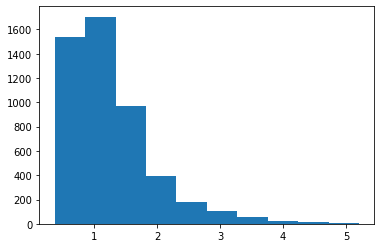

1.1567848888478311
0.08866538724376744
[0.01497406 2.00070754 2.08102296 1.95327534 2.67212201 0.        ]


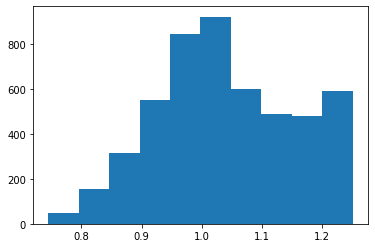

1.4634925367731615
0.45779647435299314
[ 0.07487029  4.45836028  3.23807692 -0.17324988  0.64839473  0.        ]


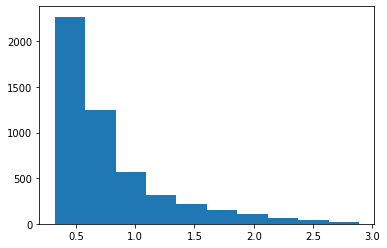

1.2740670613431422
0.14000434600596665
[0.02669517 2.48164625 2.30744715 1.53713507 2.27609829 0.        ]


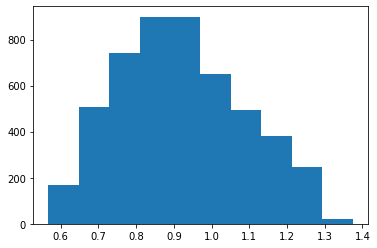

1.1486837803709495
0.10283521155886151
[1.46940327e-02 1.94659306e+00 2.09576521e+00 1.99631383e+00
 2.64629651e+00 3.87102020e-05]


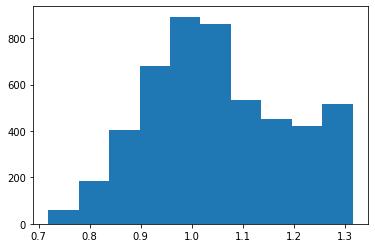

1.2170171770567388
0.051071721456457525
[2.09990058e-02 2.22769113e+00 2.20697543e+00 1.75507751e+00
 2.45180743e+00 1.83732278e-05]


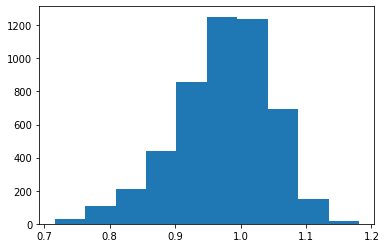

1.0351368213861243
0.30772546773962317
[4.36483175e-02 1.72121998e+00 1.47997388e+00 2.37978795e+00
 3.13951142e+00 1.79188856e-05]


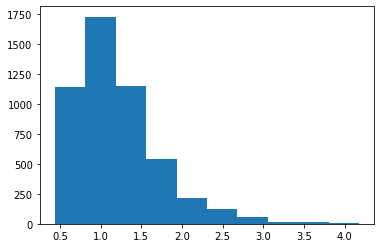

1.1941013597763448
0.04326753292955906
[2.40354956e-02 2.15979085e+00 2.10950965e+00 1.83882959e+00
 2.54400476e+00 1.83123162e-05]


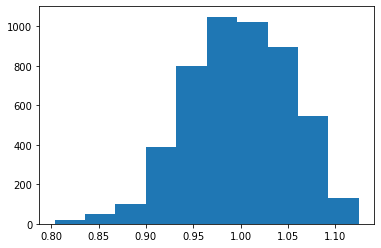

1.200824907632349
0.035729966558249705
[3.07845492e-02 2.21369022e+00 2.06014551e+00 1.81483414e+00
 2.55333406e+00 2.68674615e-05]


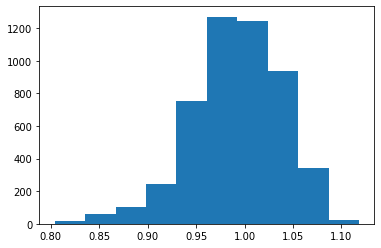

1.2223445046699128
0.038753151716137246
[7.49860341e-02 2.45716176e+00 1.70802402e+00 1.75572437e+00
 2.67505404e+00 1.13459358e-04]


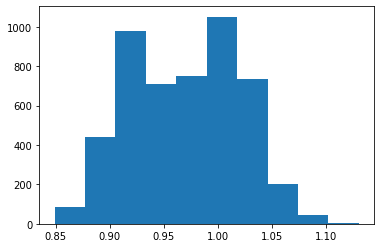

1.2100929290590487
0.026448119858461534
[5.11484625e-02 2.32585915e+00 1.89792084e+00 1.78760188e+00
 2.60941125e+00 6.67609147e-05]


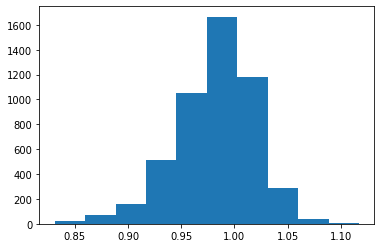

1.2076605864690106
0.021768304762149387
[6.79241586e-02 2.36235803e+00 1.77712453e+00 1.79781698e+00
 2.67380684e+00 8.34511472e-05]


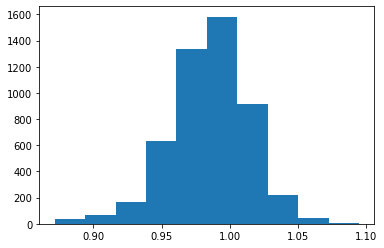

1.2031613847314222
0.019501006409996753
[1.11911731e-01 2.37863527e+00 1.68541695e+00 1.83448786e+00
 2.70410737e+00 2.56524162e-04]


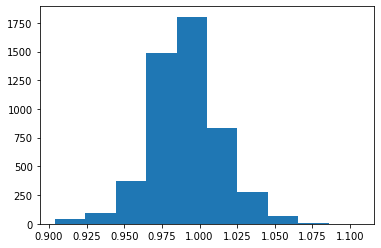

1.2027989740147471
0.019112284189994586
[1.33881900e-01 2.38635758e+00 1.66305279e+00 1.84909693e+00
 2.70023249e+00 3.91931895e-04]


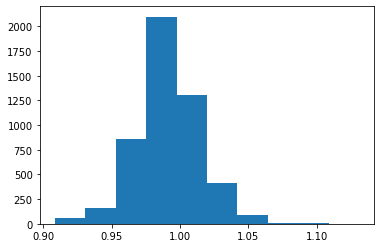

1.2035278356996584
0.017783862579901877
[2.22029254e-01 2.41502969e+00 1.60478169e+00 1.89989103e+00
 2.66259611e+00 1.14861259e-03]


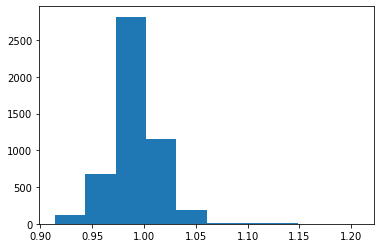

1.2047770896127707
0.01690307417477566
[0.40087137 2.41702304 1.55498844 1.91829826 2.6132443  0.00659316]


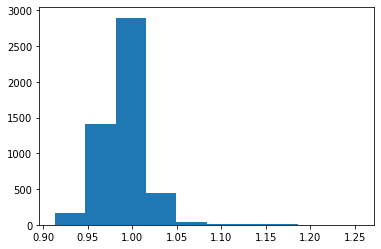

1.2044883696782338
0.01680214706325627
[0.37717678 2.40385222 1.5784983  1.91099096 2.6052237  0.00588798]


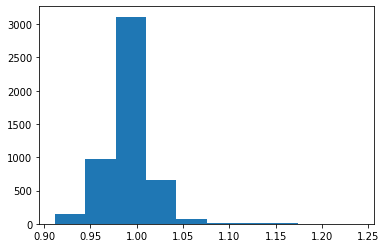

1.2044433195911015
0.016754141677871058
[0.37261642 2.38464273 1.58964397 1.89292878 2.59613395 0.00622824]


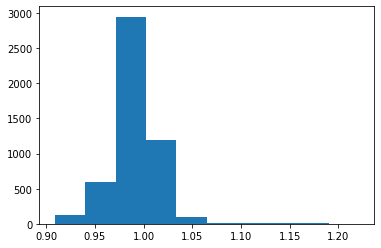

1.2045014459523569
0.016712639902319533
[0.37318835 2.36268553 1.58698439 1.87116198 2.58271252 0.00624572]


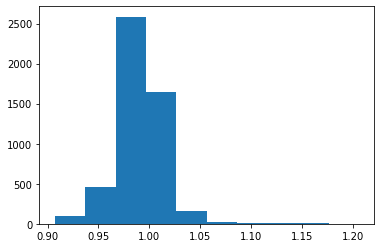

1.2044545927990715
0.016637337209542406
[0.38521475 2.30918148 1.5648721  1.82267202 2.54311651 0.00664381]


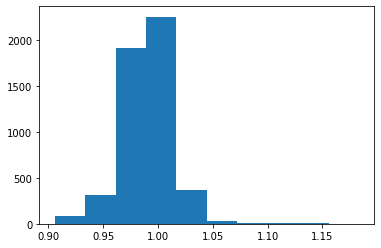

1.2047607624080252
0.016488920870218707
[0.37911262 2.22973491 1.50966245 1.75068887 2.47298174 0.00857942]


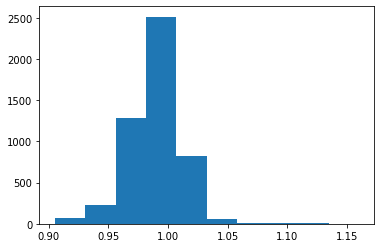

1.2062982590706692
0.016019936833217566
[0.33280358 1.89751403 1.23647714 1.46464616 2.15723358 0.01815651]


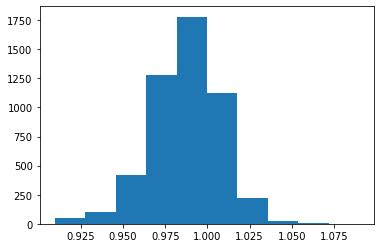

1.2063431161975822
0.015344018228873909
[0.31212234 1.78513802 1.10948863 1.38537972 2.02686492 0.02276431]


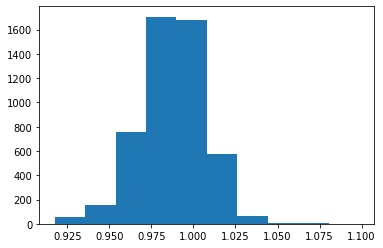

1.2084401763130639
0.013782261493223008
[0.22939736 1.33563398 0.60153462 1.06831398 1.50539029 0.04119548]


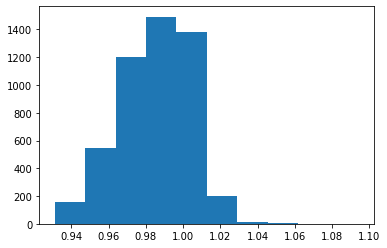

1.1978912351066018
0.017813156355113696
[0.15144089 1.08487391 0.03971807 1.04939534 1.00498128 0.06224337]


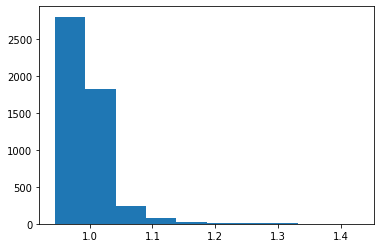

1.2054371631165848
0.012134918991739267
[0.20346458 1.25221684 0.41464231 1.06202056 1.33892563 0.04819722]


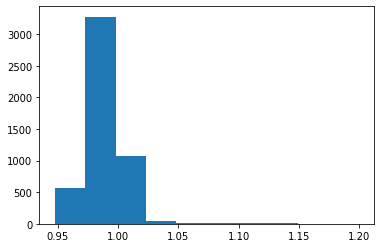

1.207112011569125
0.011214988451218943
[0.21522415 0.85152761 0.01053972 0.82615337 0.84968979 0.06345842]


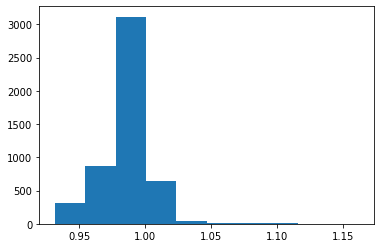

1.2060059970550603
0.010714942445512795
[0.1839027  0.78518831 0.26726808 0.77724054 0.93275267 0.03507312]


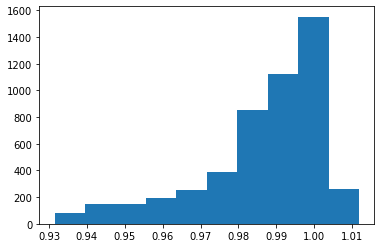

1.2065552999179547
0.01033295948566579
[0.20142768 0.82230648 0.12362343 0.80460825 0.88627733 0.05095527]


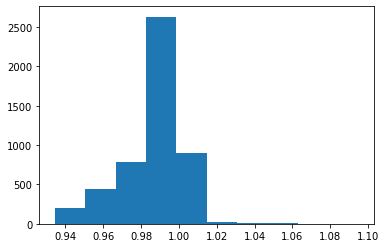

1.202588686650649
0.010864974260722674
[0.19247158 0.7245701  0.26535224 0.79124115 0.82861262 0.02486374]


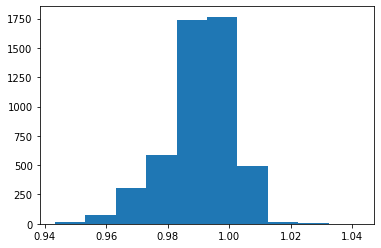

1.2048525778983155
0.009845409343495436
[0.19779447 0.78265789 0.18111837 0.79918563 0.86288456 0.04037075]


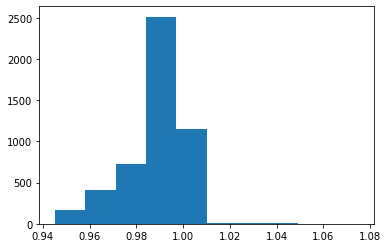

1.2053203903122853
0.010211768213913647
[0.13680968 0.65079361 0.10139143 0.72576735 0.72825716 0.0362729 ]


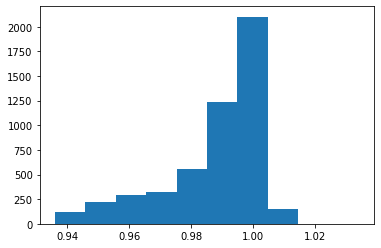

1.2049332472860836
0.009782424393500294
[0.18073824 0.74577809 0.15882034 0.77865201 0.82523197 0.03922466]


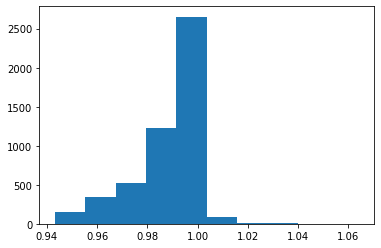

1.204093009479873
0.009883806741172235
[0.18068478 0.71104153 0.07881104 0.77515344 0.74429746 0.03893783]


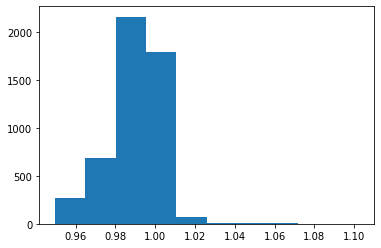

1.204656066300455
0.009739685051820353
[0.18071987 0.73384006 0.13132328 0.77744964 0.79741694 0.03912609]


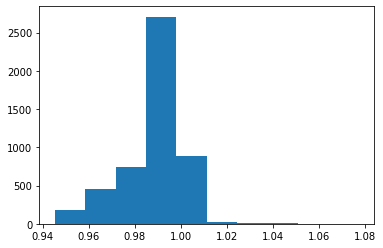

1.204709365974412
0.009725133254860139
[0.18160881 0.69239498 0.11001748 0.75551817 0.75698671 0.03761941]


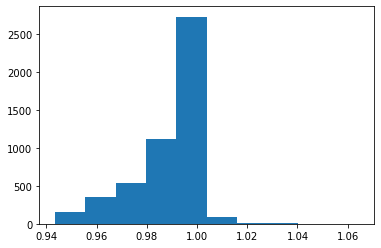

1.2032171681275057
0.009786313532977703
[0.17032814 0.69420603 0.16105826 0.752992   0.82303003 0.02124822]


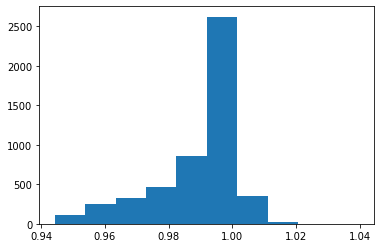

1.2041571192098208
0.009694435470159649
[0.17733209 0.69308158 0.12936803 0.75456045 0.78202502 0.03141277]


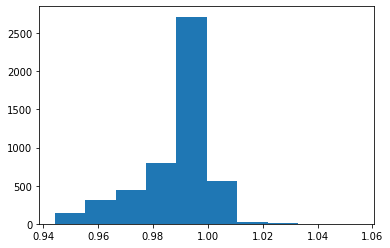

1.203929732170467
0.009691804124515797
[0.17664337 0.69488112 0.13487234 0.75707317 0.78580732 0.02919729]


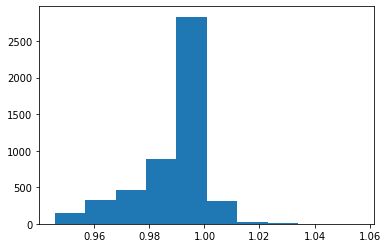

1.203897913861062
0.009690316247843568
[0.17647566 0.69854775 0.13610428 0.75948553 0.78822811 0.02795239]


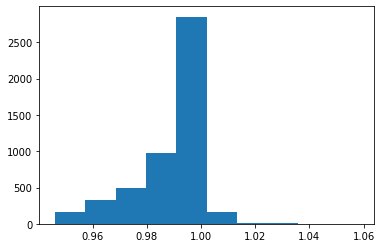

1.2037985052598366
0.009686338417500313
[0.17578485 0.71006783 0.14261951 0.76645726 0.79869503 0.01714256]


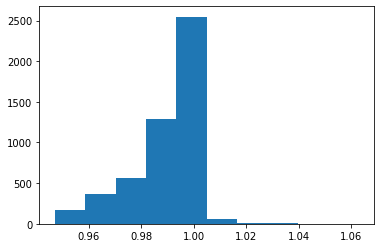

1.2039915946761208
0.009682194720384334
[0.17795759 0.70441016 0.13595575 0.76208524 0.79195061 0.00791816]


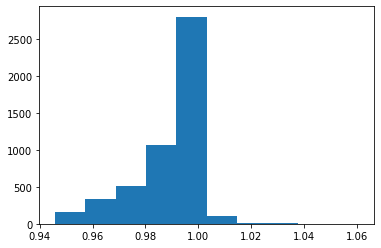

1.2041020076524205
0.009681664382168215
[0.17843688 0.69614476 0.13144945 0.75676199 0.7845432  0.00997926]


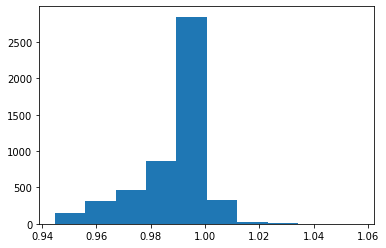

In [23]:
#res = minimize(integration, g0, method='L-BFGS-B', options={'iprint':1, 'ftol': 1e-04, 'eps': 1e-02, 'maxiter':20})
res = minimize(integration, g0, method='L-BFGS-B', options={'ftol': 1e-06, 'maxiter':200})

In [ ]:
print(res.x)

In [ ]:
h_minimal = param_to_matrix(res.x, h_sym)

In [ ]:
sigma = HS.integrate(lambda patch: tf.abs(patch.num_eta_tf(h_minimal)/factor - 1), tensor=True)
delta_sigma = math.sqrt(HS.integrate(lambda patch: (tf.abs(patch.num_eta_tf(h_minimal)/factor - 1) - sigma)**2, 
                                     tensor=True) / HS.n_points)

In [ ]:
print(sigma)
print(delta_sigma)

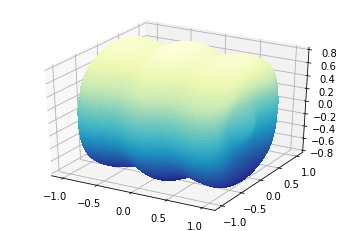

In [18]:
#param = [0.8, 0.8]
param = [-0.13814375, -0.16041894 ,-0.90220166 , 0.3039817 ,  0.08749082 , 0.11340696]
h_minimal = param_to_matrix(param)
#h_minimal = 'identity'
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.001,np.pi+0.001, 100), np.linspace(0.001, 2*np.pi+0.001, 100)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, complex(t), 0, -complex(t)])/factor 
            #print('test',np.absolute(t**4))
            #print(patch.restriction([1, -1, complex(t), 0, -complex(t)]))
            #print("t<=1", t)
        else:
            #eta = 0
            eta = patch.num_eta(h_minimal, [1, -1, complex(1/t), 0, -complex(1/t)])/factor
  
            #print('test',np.absolute(t**4), 1/t**4)
        theta_list.append(float(eta))
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
ZZ = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_zlim3d(-0.8, 0.8)
plot = ax.plot_surface(
    X, Y, ZZ, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)


Standard deviation of eta:

In [19]:
sum_eta_sq = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = sum_eta = 0
mean_abs_eta = 0
for patch in HS.patches:
    for subpatch in patch.patches:
        for point in subpatch.points:
            #print(subpatch.num_eta(h_minimal, point)*factor - 1)
            eta = subpatch.num_eta(h_minimal, point)
            sum_eta_sq += (eta/factor - 1)**2
            mean_abs_eta += abs(eta/factor - 1)
print(math.sqrt((sum_eta_sq-mean_abs_eta**2/HS.n_points)/(HS.n_points - 1)))

0.21875651133455828


In [ ]:
# k = 6, 20k points
g0 = [ 1.34324125e-03, -3.96012401e-01 , 2.45408482e+00 , 4.22872089e-02,
 -1.14449106e-01 , 3.57388925e+00,  3.41178473e-02 , 4.00246942e+00,
  4.45253468e-02 , 3.45675943e+00, -1.30400261e-03 , 3.94223532e+00,
  4.39484235e+00 , 4.17491341e+00 , 3.86355451e+00 , 5.39889715e+00,
 -1.53971471e-06, -1.08164686e-04,  1.64251667e-04 ,3.76561480e-05,
  2.47039528e-04,  9.06781544e-04 , 4.10003787e-06]

In [55]:
a = np.ones(1000)

In [56]:
a= np.concatenate((a,[10]))

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

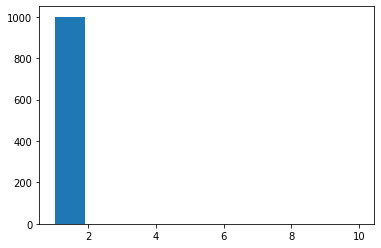

In [57]:
plt.hist(a)